In [1]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import gensim
import networkx as nx
from matplotlib import cm
import opencorpora
from pymystem3 import Mystem
from many_stop_words import get_stop_words
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if not os.path.exists('tmp/doc2vec'):
    os.mkdir('tmp/doc2vec')
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
code = pd.read_csv('tmp/criminal_code.csv')
df = pd.read_csv('tmp/judicial_orders.csv').rename(columns={'title':'name'})
code['lemmas'] = code['lemmas'].map(eval)
df['lemmas'] = df['lemmas'].map(eval)

## Статьи кодекса и судебные решения

In [56]:
code['source'] = 'criminal_code'
df['source'] = 'judgement'

In [57]:
tmp = pd.concat([
    code[['name', 'lemmas','source']], 
    df[['name', 'lemmas', 'source']]
], ignore_index=True)

In [58]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [66]:
tmp.loc[171]

name                                        Подмена ребенка
lemmas    [подмена, ребенок, совершенный, корыстный, низ...
source                                        criminal_code
Name: 171, dtype: object

In [7]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 46min 24s, sys: 48.8 s, total: 47min 13s
Wall time: 17min 30s


In [8]:
model.save('tmp/doc2vec/cc_j_model.model')

In [9]:
docvec = dict(zip(model.docvecs.offset2doctag, model.docvecs.vectors_docs.tolist()))

In [10]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()

In [11]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

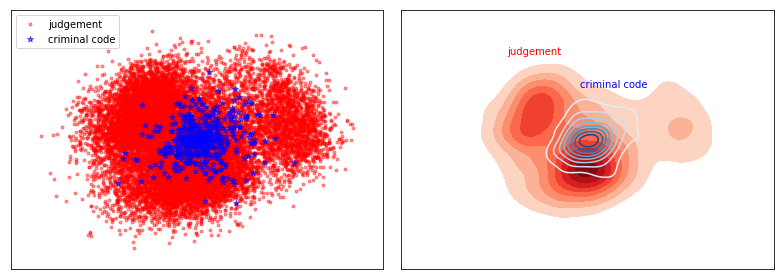

In [12]:
pca_j = np.array(tmp[tmp['source'] == 'judgement']['pca'].tolist())
pca_cc = np.array(tmp[tmp['source'] == 'criminal_code']['pca'].tolist())

disable_ticks = lambda x: x.tick_params(axis='both', which='both', left=False, bottom=False,
                                        labelleft=False, labelbottom=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), sharex='all', sharey='all')
ax1.scatter(pca_j[:, 0], pca_j[:, 1], c='r', marker='.', label='judgement', alpha=.4)
ax1.scatter(pca_cc[:, 0], pca_cc[:, 1], c='b', marker='*', label='criminal code', alpha=.6)
disable_ticks(ax1)
ax1.legend()

ax2 = sns.kdeplot(pca_j[:, 0], pca_j[:, 1], ax=ax2, legend=False, 
                  cmap='Reds', shade=True, shade_lowest=False)
ax2.text(-5, 8, "judgement", size=10, color='red')
ax2 = sns.kdeplot(pca_cc[:, 0], pca_cc[:, 1], ax=ax2, legend=False, 
                  cmap='Blues', shade_lowest=False)
ax2.text(0, 5, "criminal code", size=10, color='blue')
disable_ticks(ax2)

plt.tight_layout()
plt.autoscale()
plt.savefig('tmp/space_plot_j.png', dpi=300)
plt.show()

In [13]:
patt = re.compile("\\n|\\t|\\r")
clean_str = lambda s: re.sub(patt, ' ', s)

In [14]:
tmp['name'] = tmp['name'].map(clean_str)

In [15]:
tmp.drop(['lemmas'], axis=1).to_csv('results/doc2vec_all.csv', index=False)

### Вместе с opencorpora

Скачать архив opencorpora: 
`opencorpora download`

In [20]:
reader = opencorpora.CorpusReader('data/annot.opcorpora.xml')

In [21]:
m = Mystem(entire_input=False)

In [22]:
def lemm_and_filter(text, stopwords=get_stop_words('ru')):
    lemmas = m.lemmatize(text)
    filter_cond = lambda word: word not in stopwords and len(word) > 3
    return list(filter(filter_cond, lemmas))

In [23]:
%%time
docs_iter = reader.iter_documents()
corpus = [(doc.title(), doc.raw(), lemm_and_filter(doc.raw())) for doc in docs_iter]

CPU times: user 7min 53s, sys: 38.9 s, total: 8min 32s
Wall time: 10min 35s


In [24]:
tmp = pd.DataFrame(corpus, columns=['name', 'body', 'lemmas'])

In [25]:
tmp = tmp.drop(tmp[tmp['lemmas'].map(len) == 0].index)

In [26]:
tmp['source'] = 'opencorpora'
code['source'] = 'criminal_code'
df['source'] = 'judgement'

In [27]:
tmp = pd.concat([
    tmp,
    code[['name', 'body', 'lemmas', 'source']],
    df.rename(columns={'case':'body'})[['name', 'body', 'lemmas', 'source']]
], ignore_index=True)

In [28]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [29]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 54min 14s, sys: 1min 8s, total: 55min 23s
Wall time: 20min 52s


In [31]:
model.save('tmp/doc2vec/oc_cc_j_model.model')

Восстановление модели

In [32]:
model = gensim.models.doc2vec.Doc2Vec.load('tmp/doc2vec/oc_cc_j_model.model')

In [33]:
tmp['name'] = tmp['name'].map(clean_str)

In [34]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_with_opencorpora.csv', index=False)

In [35]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

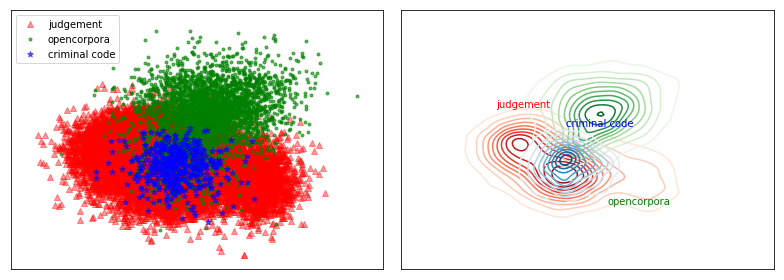

In [36]:
pca_j = np.array(tmp[tmp['source'] == 'judgement']['pca'].tolist())
pca_cc = np.array(tmp[tmp['source'] == 'criminal_code']['pca'].tolist())
pca_oc = np.array(tmp[tmp['source'] == 'opencorpora']['pca'].tolist())

disable_ticks = lambda x: x.tick_params(axis='both', which='both', left=False, bottom=False,
                                        labelleft=False, labelbottom=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), sharex='all', sharey='all')
ax1.scatter(pca_j[:, 0], pca_j[:, 1], c='r', marker='^', label='judgement', alpha=.4)
ax1.scatter(pca_oc[:, 0], pca_oc[:, 1], c='g', marker='.', label='opencorpora', alpha=.6)
ax1.scatter(pca_cc[:, 0], pca_cc[:, 1], c='b', marker='*', label='criminal code', alpha=.6)
disable_ticks(ax1)
ax1.legend()

ax2 = sns.kdeplot(pca_j[:, 0], pca_j[:, 1], ax=ax2, legend=False, 
                  cmap='Reds', shade_lowest=False)
ax2.text(-5, 5, "judgement", size=10, color='red')
ax2 = sns.kdeplot(pca_oc[:, 0], pca_oc[:, 1], ax=ax2, legend=False, 
                  cmap='Greens',shade_lowest=False)
ax2.text(3, -5, "opencorpora", size=10, color='green')
ax2 = sns.kdeplot(pca_cc[:, 0], pca_cc[:, 1], ax=ax2, legend=False, 
                  cmap='Blues',shade_lowest=False)
ax2.text(0, 3, "criminal code", size=10, color='blue')
disable_ticks(ax2)

plt.tight_layout()
plt.autoscale()
plt.show()

In [37]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)[['name', 'source', 'vectors']]

In [38]:
tmp_500.to_csv('results/doc2vec_light.csv', index=False)

## Используя фразы

In [39]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=tmp['lemmas']))

In [40]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=phraser[row['lemmas']], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [41]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 47min 29s, sys: 1min 24s, total: 48min 53s
Wall time: 19min 10s


In [42]:
model.save('tmp/doc2vec/ph_oc_cc_j_model.model')

Восстановление модели

In [43]:
model = gensim.models.doc2vec.Doc2Vec.load('tmp/doc2vec/ph_oc_cc_j_model.model')

In [44]:
tmp['name'] = tmp['name'].map(clean_str)
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_phrases.csv', index=False)

In [45]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

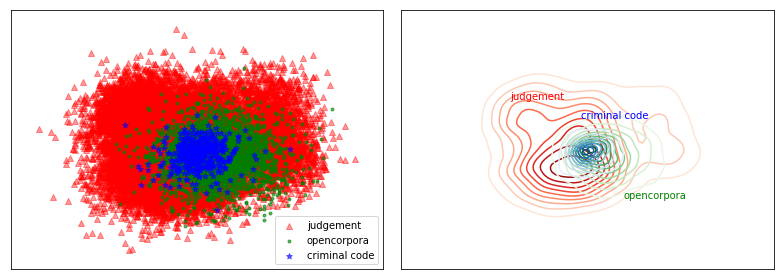

In [46]:
pca_j = np.array(tmp[tmp['source'] == 'judgement']['pca'].tolist())
pca_cc = np.array(tmp[tmp['source'] == 'criminal_code']['pca'].tolist())
pca_oc = np.array(tmp[tmp['source'] == 'opencorpora']['pca'].tolist())

disable_ticks = lambda x: x.tick_params(axis='both', which='both', left=False, bottom=False,
                                        labelleft=False, labelbottom=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4), sharex='all', sharey='all')
ax1.scatter(pca_j[:, 0], pca_j[:, 1], c='r', marker='^', label='judgement', alpha=.4)
ax1.scatter(pca_oc[:, 0], pca_oc[:, 1], c='g', marker='.', label='opencorpora', alpha=.6)
ax1.scatter(pca_cc[:, 0], pca_cc[:, 1], c='b', marker='*', label='criminal code', alpha=.6)
disable_ticks(ax1)
ax1.legend()

ax2 = sns.kdeplot(pca_j[:, 0], pca_j[:, 1], ax=ax2, legend=False, 
                  cmap='Reds', shade_lowest=False)
ax2.text(-5, 5, "judgement", size=10, color='red')
ax2 = sns.kdeplot(pca_oc[:, 0], pca_oc[:, 1], ax=ax2, legend=False, 
                  cmap='Greens',shade_lowest=False)
ax2.text(3, -5, "opencorpora", size=10, color='green')
ax2 = sns.kdeplot(pca_cc[:, 0], pca_cc[:, 1], ax=ax2, legend=False, 
                  cmap='Blues',shade_lowest=False)
ax2.text(0, 3, "criminal code", size=10, color='blue')
disable_ticks(ax2)

plt.tight_layout()
plt.autoscale()
plt.savefig('space_plot.png', dpi=300)


In [47]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)

In [48]:
tmp_500.drop(['body', 'lemmas', 'pca'], axis=1).to_csv('results/doc2vec_phrases_light.csv', index=False)

## Измерение расстояний между множествами

### Расстояние Хаусдорфа

In [ ]:
from scipy.spatial.distance import directed_hausdorff

In [ ]:
def sym_hausdorff(u, v):
    '''Find the general (symmetric) Hausdorff distance between two 2-D arrays of coordinates'''
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

In [ ]:
cc = np.array(tmp[tmp['source'] == 'criminal_code']['vectors'].tolist())
oc = np.array(tmp[tmp['source'] == 'opencorpora']['vectors'].tolist())
jo = np.array(tmp[tmp['source'] == 'judgement']['vectors'].tolist())

In [ ]:
print("Между судебными решениями и текстами opencorpora: {}".format(sym_hausdorff(jo, oc)))

In [ ]:
print("Между статьями кодекса и текстами opencorpora: {}".format(sym_hausdorff(cc, oc)))

In [ ]:
print("Между статьями кодекса и судебными решениями: {}".format(sym_hausdorff(cc, jo)))

## Создание порогового графа Уголовного кодекса

In [56]:
from scipy.spatial.distance import cosine

In [57]:
code['vectors'] = tmp[tmp['source'] == 'criminal_code'].reset_index(drop=True)['vectors']

In [58]:
def measure_distances(vec_a):
    return code['vectors'].map(lambda vec_b: cosine(vec_a, vec_b)).tolist()

In [62]:
code['similarities'] = code['vectors'].map(measure_distances)

In [63]:
dist_matrix = np.array(code['similarities'].tolist())

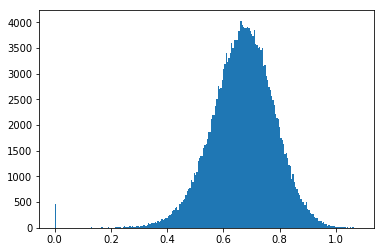

In [64]:
plt.hist(np.hstack(dist_matrix),bins='auto')
plt.savefig('kde.png', dpi=300)
plt.show()

In [73]:
to_int_if_possible = lambda x: str(int(float(x))) if float(x).is_integer() else str(x)
code['number'] = code['number'].map(to_int_if_possible)
code['section'] = code['section'].map(to_int_if_possible)
code['chapter'] = code['chapter'].map(to_int_if_possible)

In [74]:
chapters = {p[0]:p[1] for p in zip(code['number'].tolist(), code['chapter'].tolist())}
sections = {p[0]:p[1] for p in zip(code['number'].tolist(), code['section'].tolist())}

In [75]:
graph = nx.from_pandas_adjacency(
    pd.DataFrame(
        dist_matrix, 
        index=code['number'], 
        columns=code['number']
    )
)
nx.set_node_attributes(graph, chapters, name='chapter')
nx.set_node_attributes(graph, sections, name='section')

In [76]:
nx.write_gexf(graph, 'graph_full.gexf')

In [77]:
deg = graph.degree()
sub = graph.subgraph([n for n in graph.nodes if deg[n] != 0])

In [78]:
def plot_graph(threshold):
    graph = nx.from_pandas_adjacency(
        pd.DataFrame(filter_matrix(dist_matrix, threshold), 
                     index=code['number'], columns=code['number']))
    # Выбрасываем вершины без связей
    deg = graph.degree()
    sub = graph.subgraph([n for n in graph.nodes if deg[n] != 0])
    colors=list(map(lambda x: code[code['number'] == x]['section'].values[0], sub.nodes))
    return nx.draw_networkx(sub, pos=nx.drawing.kamada_kawai_layout(sub),
                            font_color='black', edge_color='grey', 
                            font_size=9, node_color=colors, font_weight='bold',
                            cmap=cm.Set1, node_size=100)

/home/gzhigalov/projects/criminal-code-nlp/cc_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


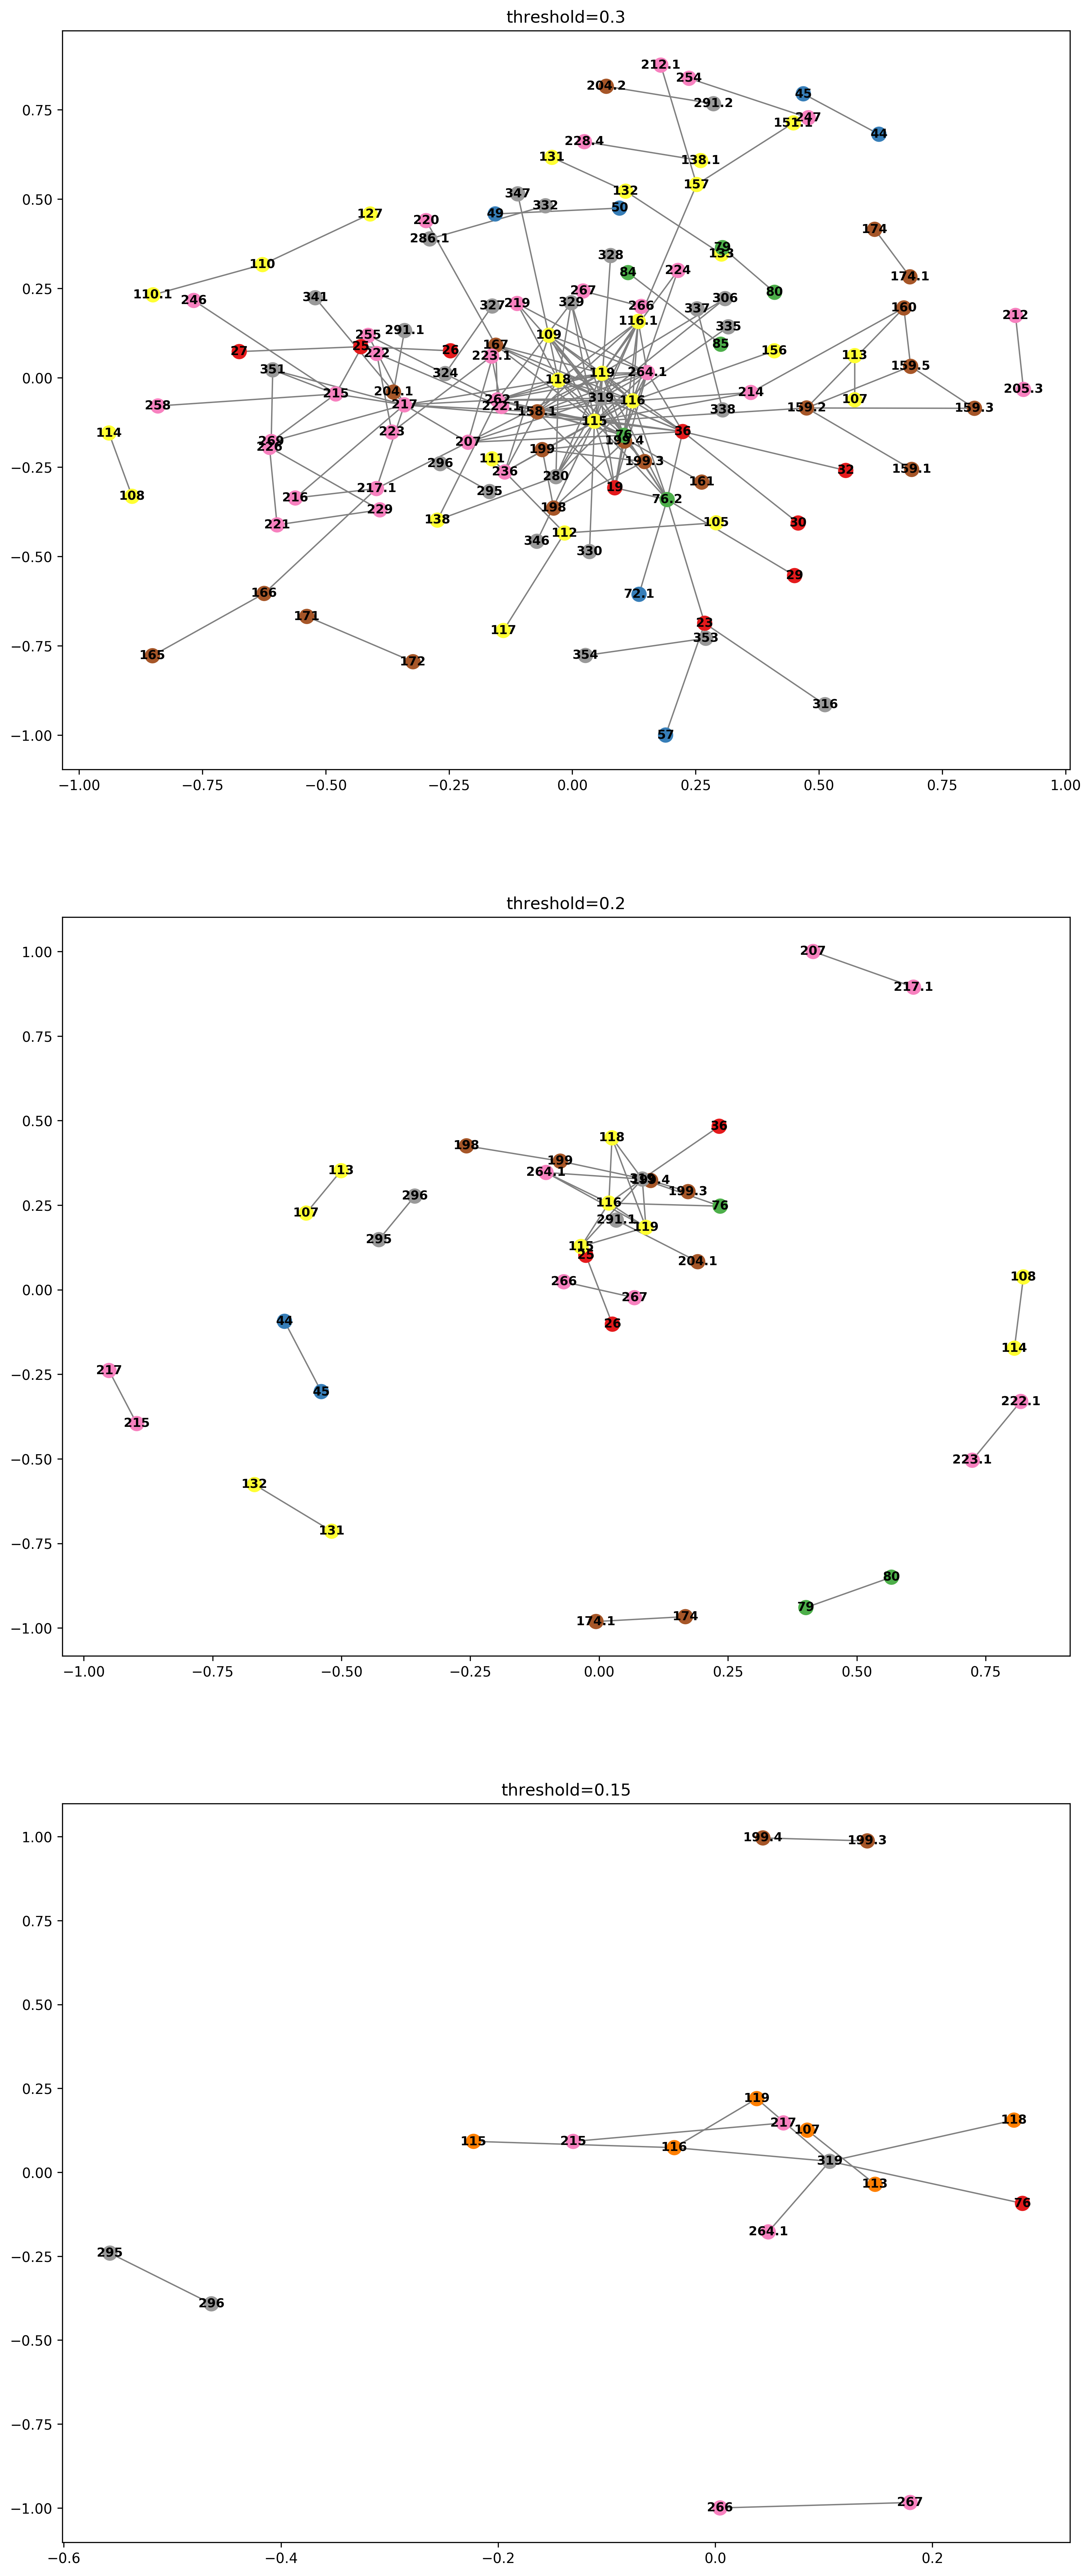

In [79]:
t = [0.3, 0.2, 0.15]
fig = plt.figure(figsize=(13, 45), dpi=300)
for i, ti in enumerate(t):
    fig.add_subplot(4,1,i+1)
#     plt.axis('off')
    plt.title('threshold={}'.format(ti))
    plot_graph(ti)

## Предсказание статей УК в резолютивной части судебного решения

Загружаем тестовую выборку судебных решений:

In [ ]:
test = pd.read_csv('data/test_jo.csv')
test['lemmas'] = test['lemmas'].map(eval)
test['labels'] = test['labels'].map(eval)

In [ ]:
test.shape

In [ ]:
df['vectors'] = tmp[tmp['source'] == 'judgement']['vectors'].tolist()
df['labels'] = df['labels'].map(eval)

Предсказываем вектора для тестовых текстов:

In [ ]:
test['vectors'] = test['lemmas'].map(model.infer_vector)

In [ ]:
plt.subplots(figsize=(15,10), dpi=300)
pca = PCA(n_components=2)
tmp['pca'] = pca.fit_transform(tmp['vectors'].tolist()).tolist()
test['pca'] = pca.transform(test['vectors'].tolist()).tolist()
for source in ['opencorpora', 'judgement', 'criminal_code']:
    plt.scatter(
        x=tmp[tmp['source'] == source]['pca'].map(lambda x: x[0]),
        y=tmp[tmp['source'] == source]['pca'].map(lambda x: x[1]),
        label=source, 
        alpha=.6)
plt.scatter(
    x=test['pca'].map(lambda x: x[0]),
    y=test['pca'].map(lambda x: x[1]),
    label='test',
    marker='*',
    c='red',
    alpha=0.5
)
plt.tick_params(
    axis='both',          
    which='both',
    left='off',
    bottom='off',      
#     top='off',
    labelleft='off',
    labelbottom='off')
plt.title('Расположение тестовых векторов в языковом пространстве (PCA 2 components)')
plt.legend()
pass

In [ ]:
df['target'] = df['labels'].map(lambda x: x[0]).astype(str)
test['target'] = test['labels'].map(lambda x: x[0]).astype(str)

In [ ]:
X_train = np.array(df['vectors'].tolist())
y_train = np.array(df['target'].tolist())

X_test = np.array(test['vectors'].tolist())
y_test = np.array(test['target'].tolist())

In [ ]:
df['target'].hist(bins=df['target'].unique().shape[0])
plt.grid(False)
plt.title('Плотность классов в тестовой выборке')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom='off',      
    labelbottom='off')
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [ ]:
accuracy_score(clf.predict(X_test), y_test)

### SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = SVC(C=10).fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

In [ ]:
test['pred'] = y_pred
test[['title','category','region','judge','case', 'target', 'pred']].head(10)